In [13]:
from torch_geometric.data import Dataset, Data
from torch_geometric.nn import knn_graph
import os.path as osp
import pandas as pd
import numpy as np
import torch
import h5py

class AudioGraphDataset(Dataset):
    def __init__(self, root, path, k_neigh=5, enable=False, transform=None, pre_transform=None, pre_filter=None):
        """
        Initialize the Audio Graph Dataset
        Args:
            root: Root directory for processed files
            path: List containing paths to [csv_file, hdf5_file]
            k_neigh: Number of nearest neighbors for graph construction
            enable: Flag for extended processing mode
            transform: Transform to be applied to the data
            pre_transform: Transform to be applied before processing
            pre_filter: Filter to be applied before processing
        """
        self.csv_path = path[0]
        self.hdf5_path = path[1]
        self.enable = enable
        self.k_neigh = k_neigh
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        # Return the actual filenames without full paths
        return [osp.basename(self.csv_path), osp.basename(self.hdf5_path)]

    @property
    def raw_dir(self) -> str:
        # Return the directory containing the raw files
        return osp.dirname(self.csv_path)

    @property
    def processed_file_names(self):
        # Return list of processed file names based on enable flag
        if not self.enable:
            return [f'data_{i}.pt' for i in range(10)]
        else:
            return [f'data_{i}.pt' for i in range(109)]

    def download(self):
        # No download needed as we're using local files
        pass

    def process(self):
        """
        Process the raw data into graph format
        - Loads features and labels from HDF5
        - Performs cross-validation splits
        - Creates graph structure using kNN
        - Saves processed graphs
        """
        # Load metadata and features using full paths
        self.df = pd.read_csv(self.csv_path)
        self.data = h5py.File(self.hdf5_path, 'r')
        
        # Convert features and labels to torch tensors
        X_tensor = torch.tensor(np.array(self.data['features']))
        Y_tensor = torch.tensor(np.array(self.data['labels']))

        if not self.enable:
            # Standard processing mode - 10 fold cross validation
            self._process_folds(X_tensor, Y_tensor, 0, 10)
        else:
            # Extended processing mode - varying k neighbors
            for k in range(5, 115, 10):
                start_idx = (k - 5) // 10 * 10
                self._process_folds(X_tensor, Y_tensor, start_idx, 10, k)

    def _process_folds(self, X_tensor, Y_tensor, start_idx, num_folds, k_neighbors=None):
        """
        Process data for multiple cross-validation folds
        """
        test_idx = 1
        val_idx = 2
        k = k_neighbors if k_neighbors is not None else self.k_neigh

        for j in range(start_idx, start_idx + num_folds):
            # Get train/test/validation splits
            idx_train, idx_test, idx_val = self._cross_validation_split(
                self.df, test_idx, val_idx)
            
            # Normalize features
            X_tensor_norm = self._normalize_features(X_tensor, idx_train)
            
            # Create graph data object
            data = self._create_graph(X_tensor_norm, Y_tensor, 
                                    idx_train, idx_test, idx_val, k)
            
            # Save processed data
            torch.save(data, osp.join(self.processed_dir, f'data_{j}.pt'))
            
            # Update indices for next fold
            test_idx = (test_idx + 1) % 11
            val_idx = (val_idx + 1) % 11
            if val_idx == 0:
                val_idx = 1

    def _normalize_features(self, X_tensor, idx_train):
        """
        Normalize features using min-max scaling based on training set
        """
        mini = X_tensor[idx_train].min()
        maxi = X_tensor[idx_train].max()
        return (X_tensor - mini) / (maxi - mini)

    def _cross_validation_split(self, df, idx_test, idx_val):
        """
        Create train/test/validation splits using fold information
        """
        df = df.reset_index(drop=True)
        df_train = df.copy()
        
        # Get test indices and remove from training
        idx_test_mask = df.index[df.fold == idx_test]
        df_train.drop(idx_test_mask, inplace=True)
        
        # Get validation indices and remove from training
        idx_val_mask = df.index[df.fold == idx_val]
        df_train.drop(idx_val_mask, inplace=True)
        
        # Remaining indices are training set
        idx_train_mask = df_train.index
        
        return idx_train_mask, idx_test_mask, idx_val_mask

    def _create_graph(self, X_tensor, Y_tensor, idx_train, idx_test, idx_val, k):
        """
        Create a graph using feature tensors and kNN
        """
        # Convert indices to tensors
        train_mask = torch.tensor(idx_train)
        test_mask = torch.tensor(idx_test)
        val_mask = torch.tensor(idx_val)

        # Create edge connections using kNN
        edge_index = knn_graph(X_tensor, k=k, batch=Y_tensor, loop=False)

        # Create and return the graph data object
        return Data(
            x=X_tensor,
            edge_index=edge_index,
            y=Y_tensor,
            train_mask=train_mask,
            test_mask=test_mask,
            val_mask=val_mask
        )

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        """Load and return a specific graph"""
        return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))

In [14]:
# Example usage
dataset = AudioGraphDataset(
    root='data_vggish_fixed_knn/processed',
    path=['data_vggish_fixed_knn/raw/UrbanSound8K7780.csv', 'data_vggish_fixed_knn/raw/TF_vggish_2023.hdf5'],
    k_neigh=5
)

# Access a specific graph
graph = dataset[0]

/tmp/ipykernel_98958/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))


In [15]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import torch
import numpy as np

def visualize_graph(data, title="Audio Graph Visualization", color_by='label', fig_size=(12, 8)):
    """
    Visualize the audio graph with different coloring options
    
    Args:
        data: PyG Data object containing the graph
        title: Title for the visualization
        color_by: 'label' or 'split' to color nodes by class labels or train/val/test split
        fig_size: Size of the figure (width, height)
    """
    # Convert to networkx graph
    G = to_networkx(data, to_undirected=True)
    
    # Get node positions using spring layout
    pos = nx.spring_layout(G, k=0.5)  # k controls the distance between nodes
    
    plt.figure(figsize=fig_size)
    
    if color_by == 'label':
        # Color by class labels
        labels = data.y.numpy()
        unique_labels = np.unique(labels)
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
        color_dict = dict(zip(unique_labels, colors))
        node_colors = [color_dict[label] for label in labels]
        
        # Create legend handles
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=color,
                                    label=f'Fold {label}', markersize=10)
                         for label, color in color_dict.items()]
        
    else:  # color_by == 'split'
        # Color by train/val/test split
        colors = []
        for i in range(len(G)):
            if i in data.train_mask:
                colors.append('blue')
            elif i in data.val_mask:
                colors.append('green')
            elif i in data.test_mask:
                colors.append('red')
        node_colors = colors
        
        # Create legend handles
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
                      label='Train', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green',
                      label='Validation', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
                      label='Test', markersize=10)
        ]
    
    # Draw the graph
    nx.draw(G, pos, node_color=node_colors, node_size=100, alpha=0.7)
    plt.legend(handles=legend_elements)
    plt.title(title)
    plt.show()

def visualize_graph_metrics(data):
    """
    Visualize graph metrics such as degree distribution
    
    Args:
        data: PyG Data object containing the graph
    """
    G = to_networkx(data, to_undirected=True)
    
    # Calculate degree for each node
    degrees = [d for n, d in G.degree()]
    
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=30, alpha=0.7)
    plt.xlabel('Node Degree')
    plt.ylabel('Count')
    plt.title('Degree Distribution')
    plt.show()
    
    # Print some graph statistics
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(degrees) / len(degrees):.2f}")
    print(f"Graph density: {nx.density(G):.4f}")

/tmp/ipykernel_98958/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))


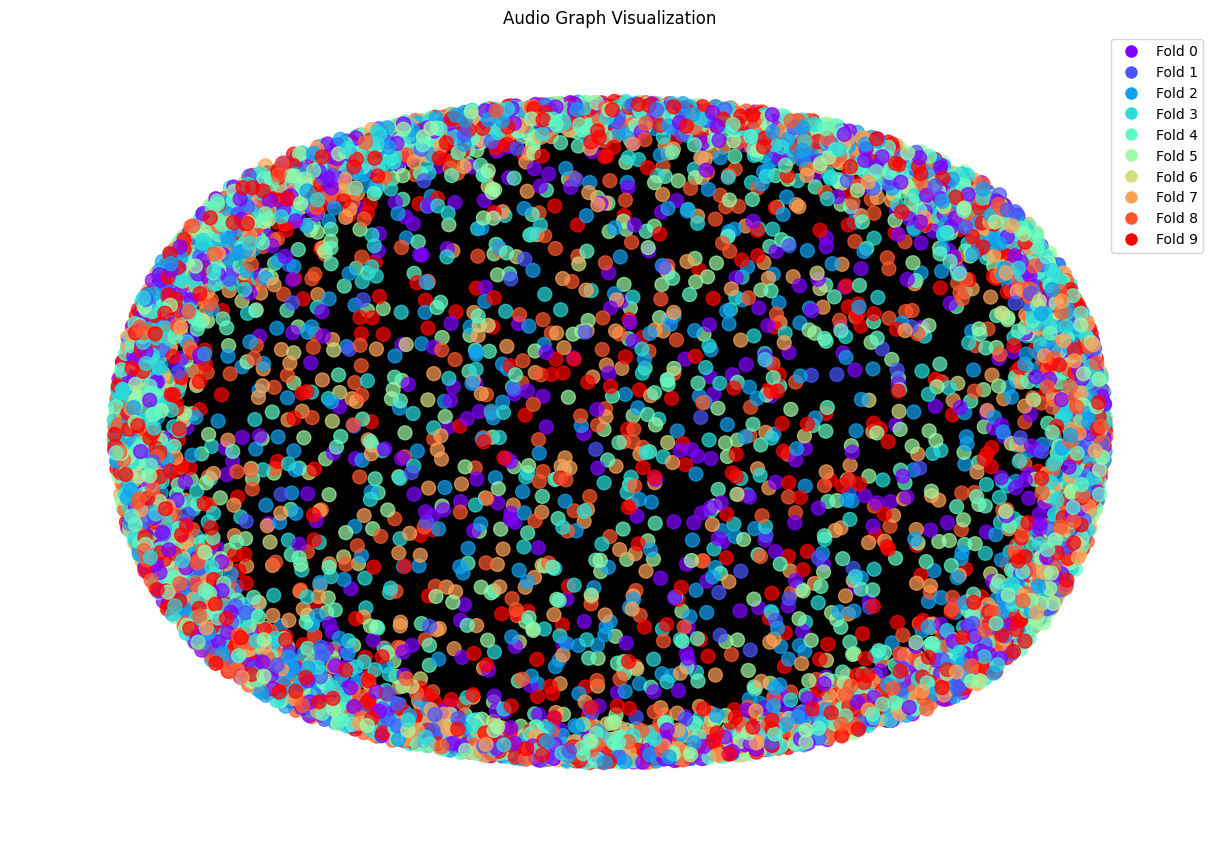

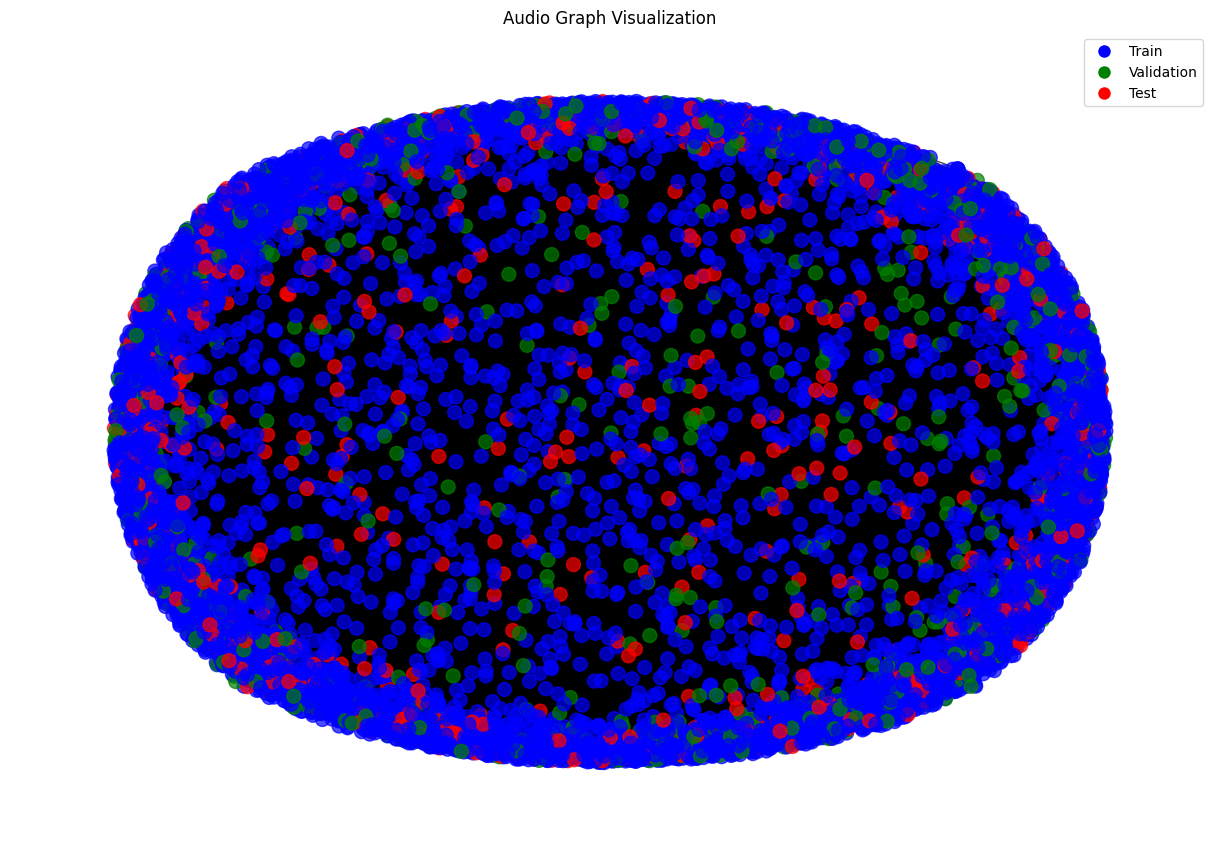

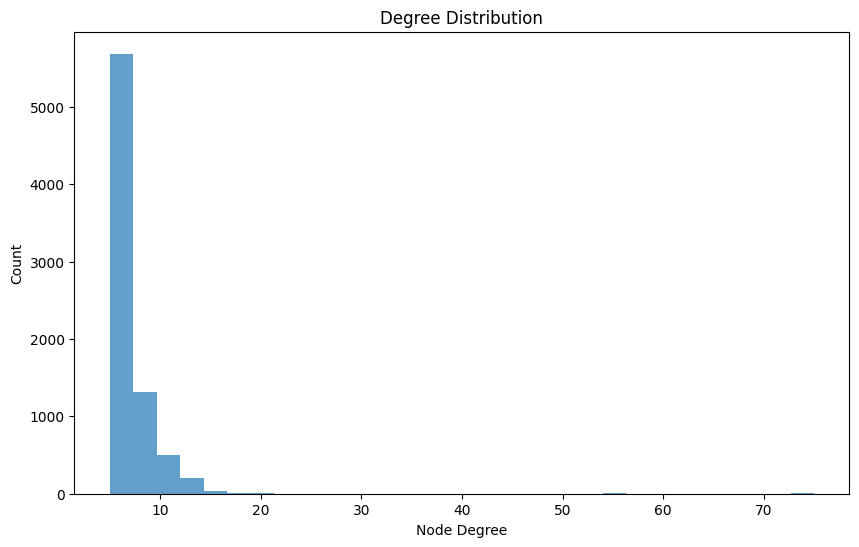

Number of nodes: 7780
Number of edges: 26575
Average degree: 6.83
Graph density: 0.0009


In [16]:
dataset = AudioGraphDataset(
    root='data_vggish_fixed_knn/processed',
    path=['data_vggish_fixed_knn/raw/UrbanSound8K7780.csv', 'data_vggish_fixed_knn/raw/TF_vggish_2023.hdf5'],
    k_neigh=5
)
# Get a specific graph
graph = dataset[0]

# Visualize the graph with nodes colored by class labels
visualize_graph(graph, color_by='label')

# Visualize the graph with nodes colored by train/val/test split
visualize_graph(graph, color_by='split')

# Visualize graph metrics
visualize_graph_metrics(graph)

In [25]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
%matplotlib inline
class GCNAudioClassifier(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.3):
        """
        GCN model for audio classification
        Args:
            num_features: Number of input features (128 for VGGish)
            hidden_channels: Number of hidden units
            num_classes: Number of output classes
            dropout: Dropout rate
        """
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)
        self.dropout = dropout
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)  # Batch normalization
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)  # Batch normalization

    def forward(self, x, edge_index):
        # First Graph Convolution
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Apply batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second Graph Convolution
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Apply batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Final Graph Convolution
        x = self.conv3(x, edge_index)
        
        return F.log_softmax(x, dim=1)

/tmp/ipykernel_98958/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))


Epoch 010, Train Loss: 1.1316, Train Acc: 0.6844, Val Loss: 1.3070, Val Acc: 0.5946
Epoch 020, Train Loss: 0.7683, Train Acc: 0.7434, Val Loss: 1.1289, Val Acc: 0.6654
Epoch 030, Train Loss: 0.5957, Train Acc: 0.7930, Val Loss: 1.0667, Val Acc: 0.6718
Epoch 040, Train Loss: 0.4960, Train Acc: 0.8350, Val Loss: 1.1559, Val Acc: 0.7053
Epoch 050, Train Loss: 0.4345, Train Acc: 0.8638, Val Loss: 1.1704, Val Acc: 0.7117
Epoch 060, Train Loss: 0.4071, Train Acc: 0.8668, Val Loss: 1.2039, Val Acc: 0.6988
Epoch 070, Train Loss: 0.3682, Train Acc: 0.8855, Val Loss: 1.3570, Val Acc: 0.7104
Epoch 080, Train Loss: 0.3506, Train Acc: 0.8932, Val Loss: 1.3098, Val Acc: 0.7053
Epoch 090, Train Loss: 0.3303, Train Acc: 0.8919, Val Loss: 1.3514, Val Acc: 0.7091
Epoch 100, Train Loss: 0.3065, Train Acc: 0.9014, Val Loss: 1.3619, Val Acc: 0.6950
Epoch 110, Train Loss: 0.3029, Train Acc: 0.9061, Val Loss: 1.4380, Val Acc: 0.7349
Epoch 120, Train Loss: 0.2866, Train Acc: 0.9083, Val Loss: 1.3597, Val Acc:

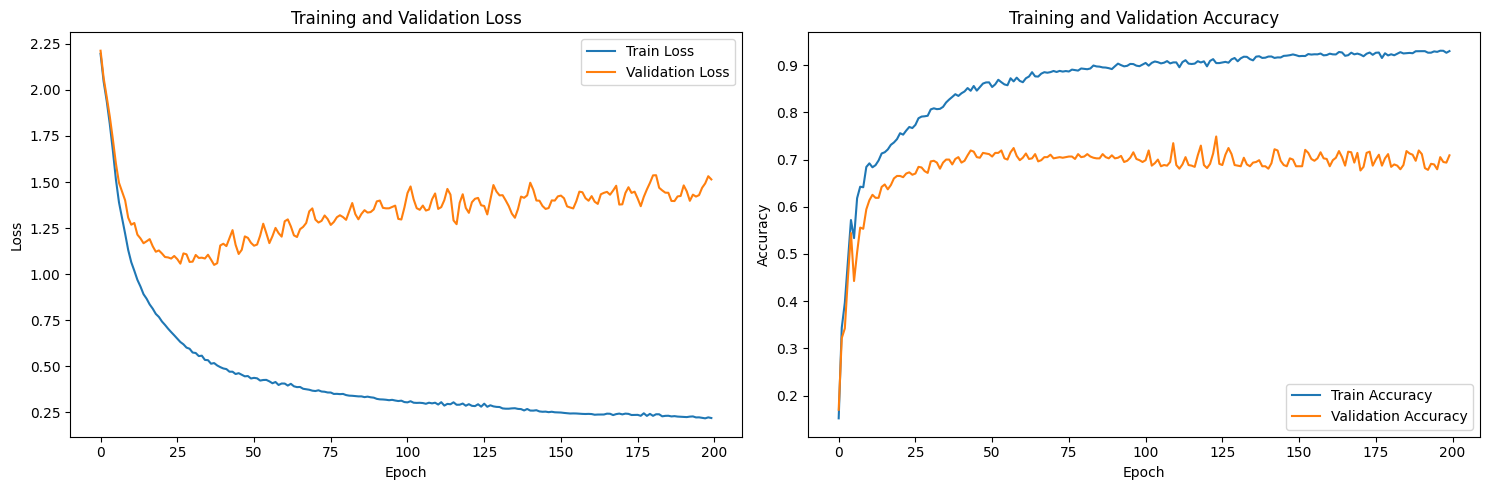


Test Set Metrics:
Accuracy: 0.6921
Precision: 0.6816
Recall: 0.6921
F1: 0.6822


In [12]:
# 2. Get a specific fold's graph
data = dataset[0]  # First fold

# 3. Setup the model
model = GCNAudioClassifier(
    num_features=128,  # VGGish features dimension
    hidden_channels=55,  # You can adjust this
    num_classes=10,    # Number of audio classes
    dropout=0.5
)

# 4. Setup optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 5. Train the model
train_losses, val_losses, train_accs, val_accs = train_model(
    model=model,
    data=data,
    optimizer=optimizer,
    epochs=200
)

# 6. Plot training curves
plot_training_curves(train_losses, val_losses, train_accs, val_accs)

# 7. Evaluate on test set
metrics = evaluate_model(model, data)
print("\nTest Set Metrics:")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

In [26]:
def train_model(model, data, optimizer, epochs=200):
    """
    Train the GCN model with early stopping
    Args:
        model: GCN model instance
        data: PyG Data object containing the graph
        optimizer: PyTorch optimizer
        epochs: Number of training epochs
    Returns:
        lists of training/validation losses and accuracies
    """
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 20  # Number of epochs to wait for improvement
    epochs_without_improvement = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        
        # Calculate loss only on training nodes
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            
            # Training metrics
            train_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]).item()
            train_acc = accuracy_score(data.y[data.train_mask].cpu(), 
                                    out[data.train_mask].argmax(dim=1).cpu())
            
            # Validation metrics
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask]).item()
            val_acc = accuracy_score(data.y[data.val_mask].cpu(), 
                                   out[data.val_mask].argmax(dim=1).cpu())
            
        # Append metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d}, '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    return train_losses, val_losses, train_accs, val_accs

In [27]:
def evaluate_model(model, data):
    """
    Evaluate the model on test set
    Args:
        model: Trained GCN model
        data: PyG Data object containing the graph
    Returns:
        dict containing various metrics
    """
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[data.test_mask].argmax(dim=1).cpu()
        true = data.y[data.test_mask].cpu()
        
        # Calculate metrics
        accuracy = accuracy_score(true, pred)
        precision, recall, f1, _ = precision_recall_fscore_support(true, pred, average='weighted')
        
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [28]:
from collections import defaultdict

def train_k_fold(dataset, hidden_channels=32, dropout=0.3, epochs=200, lr=0.01):
    """
    Perform k-fold cross validation training with L2 regularization and learning rate scheduling
    Args:
        dataset: AudioGraphDataset instance
        hidden_channels: Number of hidden units in GCN
        dropout: Dropout rate
        epochs: Number of epochs per fold
        lr: Learning rate
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Store metrics for each fold
    fold_metrics = defaultdict(list)
    all_train_losses = []
    all_val_losses = []
    all_train_accs = []
    all_val_accs = []
    
    print(f"Training on {len(dataset)} folds...")
    
    for fold in range(len(dataset)):
        print(f"\nTraining Fold {fold + 1}/{len(dataset)}")
        
        # Get graph data for current fold
        data = dataset[fold].to(device)
        
        # Initialize model for this fold
        model = GCNAudioClassifier(
            num_features=128,  # VGGish features dimension
            hidden_channels=hidden_channels,
            num_classes=10,    # UrbanSound8K classes
            dropout=dropout
        ).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)  # L2 regularization
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)  # LR scheduling
        
        # Train on this fold
        train_losses, val_losses, train_accs, val_accs = train_model(
            model=model,
            data=data,
            optimizer=optimizer,
            epochs=epochs
        )
        
        # Store training curves
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_accs.append(train_accs)
        all_val_accs.append(val_accs)
        
        # Evaluate on test set
        test_metrics = evaluate_model(model, data)
        for metric, value in test_metrics.items():
            fold_metrics[metric].append(value)
        
        print(f"Fold {fold + 1} Test Metrics:")
        for metric, value in test_metrics.items():
            print(f"{metric.capitalize()}: {value:.4f}")
    
    # Calculate average metrics across folds
    print("\nOverall Cross-Validation Results:")
    for metric, values in fold_metrics.items():
        mean_value = np.mean(values)
        std_value = np.std(values)
        print(f"{metric.capitalize()}: {mean_value:.4f} ± {std_value:.4f}")
    
    return fold_metrics, (all_train_losses, all_val_losses, all_train_accs, all_val_accs)

In [29]:
def plot_k_fold_curves(all_train_losses, all_val_losses, all_train_accs, all_val_accs):
    """Plot average training curves across all folds with standard deviation"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Find the maximum length across all folds
    max_length = max(len(fold) for fold in all_train_losses)
    
    # Pad shorter folds with NaN values to make all folds the same length
    def pad_fold(fold, max_length):
        return np.pad(fold, (0, max_length - len(fold)), mode='constant', constant_values=np.nan)
    
    all_train_losses = [pad_fold(fold, max_length) for fold in all_train_losses]
    all_val_losses = [pad_fold(fold, max_length) for fold in all_val_losses]
    all_train_accs = [pad_fold(fold, max_length) for fold in all_train_accs]
    all_val_accs = [pad_fold(fold, max_length) for fold in all_val_accs]
    
    # Convert to numpy arrays
    all_train_losses = np.array(all_train_losses)
    all_val_losses = np.array(all_val_losses)
    all_train_accs = np.array(all_train_accs)
    all_val_accs = np.array(all_val_accs)
    
    # Calculate mean and std for losses
    train_losses_mean = np.nanmean(all_train_losses, axis=0)  # Ignore NaNs
    train_losses_std = np.nanstd(all_train_losses, axis=0)    # Ignore NaNs
    val_losses_mean = np.nanmean(all_val_losses, axis=0)      # Ignore NaNs
    val_losses_std = np.nanstd(all_val_losses, axis=0)        # Ignore NaNs
    
    # Calculate mean and std for accuracies
    train_accs_mean = np.nanmean(all_train_accs, axis=0)      # Ignore NaNs
    train_accs_std = np.nanstd(all_train_accs, axis=0)        # Ignore NaNs
    val_accs_mean = np.nanmean(all_val_accs, axis=0)          # Ignore NaNs
    val_accs_std = np.nanstd(all_val_accs, axis=0)            # Ignore NaNs
    
    # Plot losses
    epochs = range(1, len(train_losses_mean) + 1)
    ax1.plot(epochs, train_losses_mean, label='Train Loss')
    ax1.fill_between(epochs, train_losses_mean - train_losses_std, 
                    train_losses_mean + train_losses_std, alpha=0.2)
    ax1.plot(epochs, val_losses_mean, label='Validation Loss')
    ax1.fill_between(epochs, val_losses_mean - val_losses_std,
                    val_losses_mean + val_losses_std, alpha=0.2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Average Training and Validation Loss')
    
    # Plot accuracies
    ax2.plot(epochs, train_accs_mean, label='Train Accuracy')
    ax2.fill_between(epochs, train_accs_mean - train_accs_std,
                    train_accs_mean + train_accs_std, alpha=0.2)
    ax2.plot(epochs, val_accs_mean, label='Validation Accuracy')
    ax2.fill_between(epochs, val_accs_mean - val_accs_std,
                    val_accs_mean + val_accs_std, alpha=0.2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title('Average Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.show()

Training on 10 folds...

Training Fold 1/10
Epoch 010, Train Loss: 1.2323, Train Acc: 0.6859, Val Loss: 1.3723, Val Acc: 0.5650
Epoch 020, Train Loss: 0.6592, Train Acc: 0.8165, Val Loss: 1.0701, Val Acc: 0.6538
Epoch 030, Train Loss: 0.4945, Train Acc: 0.8498, Val Loss: 1.0612, Val Acc: 0.6654
Epoch 040, Train Loss: 0.4418, Train Acc: 0.8523, Val Loss: 1.2053, Val Acc: 0.6860


/tmp/ipykernel_98958/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda

Early stopping at epoch 46
Fold 1 Test Metrics:
Accuracy: 0.7646
Precision: 0.8315
Recall: 0.7646
F1: 0.7387

Training Fold 2/10
Epoch 010, Train Loss: 1.2056, Train Acc: 0.6711, Val Loss: 1.3850, Val Acc: 0.6321
Epoch 020, Train Loss: 0.7606, Train Acc: 0.7404, Val Loss: 1.1821, Val Acc: 0.6417
Epoch 030, Train Loss: 0.5303, Train Acc: 0.8254, Val Loss: 1.1940, Val Acc: 0.6619
Early stopping at epoch 36
Fold 2 Test Metrics:
Accuracy: 0.6963
Precision: 0.7512
Recall: 0.6963
F1: 0.6857

Training Fold 3/10
Epoch 010, Train Loss: 1.2761, Train Acc: 0.6802, Val Loss: 1.4000, Val Acc: 0.6167


/tmp/ipykernel_98958/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda

Epoch 020, Train Loss: 0.7101, Train Acc: 0.7865, Val Loss: 0.9897, Val Acc: 0.7197
Epoch 030, Train Loss: 0.4774, Train Acc: 0.8582, Val Loss: 0.9302, Val Acc: 0.6773
Epoch 040, Train Loss: 0.4128, Train Acc: 0.8742, Val Loss: 0.9694, Val Acc: 0.6888
Early stopping at epoch 47
Fold 3 Test Metrics:
Accuracy: 0.6524
Precision: 0.6877
Recall: 0.6524
F1: 0.6224

Training Fold 4/10
Epoch 010, Train Loss: 1.2738, Train Acc: 0.6614, Val Loss: 1.4503, Val Acc: 0.6104
Epoch 020, Train Loss: 0.6761, Train Acc: 0.7801, Val Loss: 1.0503, Val Acc: 0.6634


/tmp/ipykernel_98958/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda

Epoch 030, Train Loss: 0.5763, Train Acc: 0.8190, Val Loss: 1.0902, Val Acc: 0.6609
Epoch 040, Train Loss: 0.4583, Train Acc: 0.8533, Val Loss: 1.0327, Val Acc: 0.7028
Epoch 050, Train Loss: 0.3770, Train Acc: 0.8873, Val Loss: 0.9735, Val Acc: 0.7041
Epoch 060, Train Loss: 0.3312, Train Acc: 0.8978, Val Loss: 0.9430, Val Acc: 0.7374
Epoch 070, Train Loss: 0.2844, Train Acc: 0.9122, Val Loss: 0.8113, Val Acc: 0.7361
Epoch 080, Train Loss: 0.2554, Train Acc: 0.9188, Val Loss: 0.8811, Val Acc: 0.7645
Early stopping at epoch 88
Fold 4 Test Metrics:
Accuracy: 0.7105
Precision: 0.7180
Recall: 0.7105
F1: 0.7045

Training Fold 5/10
Epoch 010, Train Loss: 1.2737, Train Acc: 0.6311, Val Loss: 1.4335, Val Acc: 0.5864
Epoch 020, Train Loss: 0.7034, Train Acc: 0.7648, Val Loss: 1.0027, Val Acc: 0.6777
Epoch 030, Train Loss: 0.5809, Train Acc: 0.8034, Val Loss: 1.0098, Val Acc: 0.6819
Epoch 040, Train Loss: 0.4502, Train Acc: 0.8437, Val Loss: 0.9716, Val Acc: 0.6957


/tmp/ipykernel_98958/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda

Epoch 050, Train Loss: 0.4021, Train Acc: 0.8705, Val Loss: 1.0350, Val Acc: 0.7151
Epoch 060, Train Loss: 0.3411, Train Acc: 0.9019, Val Loss: 1.0252, Val Acc: 0.7137
Early stopping at epoch 61
Fold 5 Test Metrics:
Accuracy: 0.7534
Precision: 0.7410
Recall: 0.7534
F1: 0.7445

Training Fold 6/10
Epoch 010, Train Loss: 1.2307, Train Acc: 0.6960, Val Loss: 1.4292, Val Acc: 0.5789
Epoch 020, Train Loss: 0.6833, Train Acc: 0.7777, Val Loss: 1.0015, Val Acc: 0.6592
Epoch 030, Train Loss: 0.4925, Train Acc: 0.8483, Val Loss: 0.9220, Val Acc: 0.6763


/tmp/ipykernel_98958/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda

Epoch 040, Train Loss: 0.4270, Train Acc: 0.8590, Val Loss: 0.9798, Val Acc: 0.6447
Epoch 050, Train Loss: 0.3670, Train Acc: 0.8834, Val Loss: 1.0782, Val Acc: 0.6658
Early stopping at epoch 52
Fold 6 Test Metrics:
Accuracy: 0.7248
Precision: 0.7435
Recall: 0.7248
F1: 0.7241

Training Fold 7/10
Epoch 010, Train Loss: 1.2861, Train Acc: 0.7107, Val Loss: 1.4230, Val Acc: 0.6112
Epoch 020, Train Loss: 0.6546, Train Acc: 0.8056, Val Loss: 1.0341, Val Acc: 0.6811
Epoch 030, Train Loss: 0.4161, Train Acc: 0.8739, Val Loss: 1.0702, Val Acc: 0.6517


/tmp/ipykernel_98958/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda

Epoch 040, Train Loss: 0.3620, Train Acc: 0.8936, Val Loss: 1.2161, Val Acc: 0.6252
Early stopping at epoch 42
Fold 7 Test Metrics:
Accuracy: 0.7066
Precision: 0.6924
Recall: 0.7066
F1: 0.6884

Training Fold 8/10
Epoch 010, Train Loss: 1.2203, Train Acc: 0.6940, Val Loss: 1.2469, Val Acc: 0.6977
Epoch 020, Train Loss: 0.6853, Train Acc: 0.7756, Val Loss: 0.8999, Val Acc: 0.6734
Epoch 030, Train Loss: 0.5014, Train Acc: 0.8499, Val Loss: 0.8732, Val Acc: 0.7368
Epoch 040, Train Loss: 0.4228, Train Acc: 0.8681, Val Loss: 0.9526, Val Acc: 0.7206
Early stopping at epoch 47
Fold 8 Test Metrics:
Accuracy: 0.6713
Precision: 0.7428
Recall: 0.6713
F1: 0.6791

Training Fold 9/10
Epoch 010, Train Loss: 1.3123, Train Acc: 0.6513, Val Loss: 1.3017, Val Acc: 0.7039
Epoch 020, Train Loss: 0.7171, Train Acc: 0.7854, Val Loss: 0.8474, Val Acc: 0.7610
Epoch 030, Train Loss: 0.5410, Train Acc: 0.8282, Val Loss: 0.7474, Val Acc: 0.7822
Epoch 040, Train Loss: 0.4465, Train Acc: 0.8635, Val Loss: 0.8028, Va

/tmp/ipykernel_98958/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda

Early stopping at epoch 49
Fold 9 Test Metrics:
Accuracy: 0.7530
Precision: 0.7856
Recall: 0.7530
F1: 0.7477

Training Fold 10/10
Epoch 010, Train Loss: 1.1448, Train Acc: 0.6815, Val Loss: 1.1444, Val Acc: 0.6870
Epoch 020, Train Loss: 0.7930, Train Acc: 0.7242, Val Loss: 0.8812, Val Acc: 0.6870
Epoch 030, Train Loss: 0.5458, Train Acc: 0.8205, Val Loss: 0.8107, Val Acc: 0.7417
Epoch 040, Train Loss: 0.4750, Train Acc: 0.8334, Val Loss: 0.8699, Val Acc: 0.7735


/tmp/ipykernel_98958/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda

Epoch 050, Train Loss: 0.3899, Train Acc: 0.8676, Val Loss: 0.9165, Val Acc: 0.7786
Early stopping at epoch 52
Fold 10 Test Metrics:
Accuracy: 0.7543
Precision: 0.7655
Recall: 0.7543
F1: 0.7558

Overall Cross-Validation Results:
Accuracy: 0.7187 ± 0.0363
Precision: 0.7459 ± 0.0405
Recall: 0.7187 ± 0.0363
F1: 0.7091 ± 0.0393


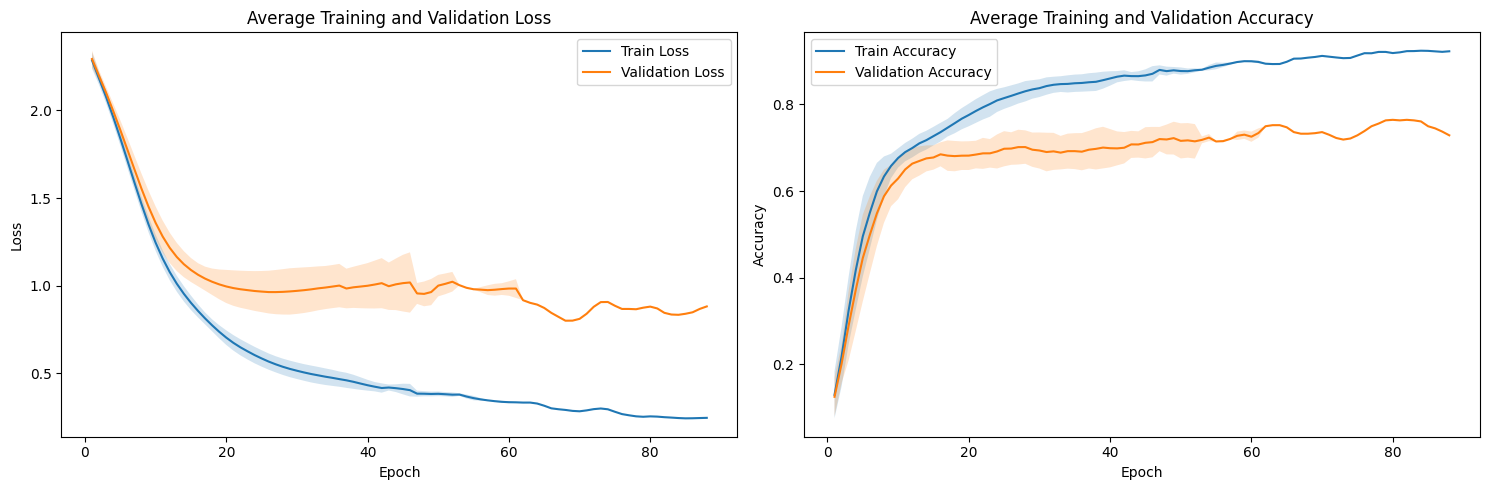

In [30]:
# Use your existing dataset
fold_metrics, curves = train_k_fold(
    dataset=dataset,
    hidden_channels=32,  # Reduced hidden channels
    dropout=0.3,         # Adjusted dropout
    epochs=200,
    lr=0.01
)

# Unpack curves
all_train_losses, all_val_losses, all_train_accs, all_val_accs = curves

# Plot average learning curves across folds
plot_k_fold_curves(all_train_losses, all_val_losses, all_train_accs, all_val_accs)